In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from importlib.metadata import version
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
# from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from IPython.display import display

# Display all plots in notebook
%matplotlib inline

print("Numpy version: " + str(np.__version__))
print("Pandas version: " + str(pd.__version__))
print("Matplotlib version: " + str(version("matplotlib")))
print("Seaborn version: " + str(sns.__version__))
print("Sklearn version: " + str(version("scikit-learn")))
print("IPython version: " + str(version("IPython")))

Numpy version: 2.3.5
Pandas version: 2.3.3
Matplotlib version: 3.10.7
Seaborn version: 0.13.2
Sklearn version: 1.7.2
IPython version: 9.7.0


In [2]:
# Read data
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

df = pd.read_csv(url)

In [3]:
df.shape

(1462, 9)

In [4]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [5]:
# Display first 5 rows of data set
print(df.head())

    lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1  
3               NaN      australia                  1        0.87          0  
4     self_employed         europe                  3        0.62          1  


In [6]:
# Missing values
print("Column missing value counts:\n")
print(df.isnull().sum())

num_missing_cols = df.isnull().any().sum()
print(f"\nThere are {num_missing_cols} columns with missing values.")

Column missing value counts:

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

There are 5 columns with missing values.


In [7]:
# Replace missing values:
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(0.0)
    else:
        df[col] = df[col].fillna("NA")

print(df.isnull().sum())

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [8]:
# Detailed descriptives for numeric columns
num_df = df.select_dtypes(include = 'number')

desc = num_df.describe(percentiles = [0.25, 0.5, 0.75]).T
desc = desc.rename(columns = {
    '25%': 'Q1',
    '50%': 'Median',
    '75%': 'Q3'
})

print(desc[['min', 'Q1', 'Median', 'mean', 'Q3', 'max', 'std']])

                          min          Q1    Median          mean        Q3  \
number_of_courses_viewed  0.0      1.0000      2.00      2.031464      3.00   
annual_income             0.0  44097.2500  57449.50  52472.172367  68241.00   
interaction_count         0.0      2.0000      3.00      2.976744      4.00   
lead_score                0.0      0.2625      0.51      0.506108      0.75   
converted                 0.0      0.0000      1.00      0.619015      1.00   

                               max           std  
number_of_courses_viewed       9.0      1.449717  
annual_income             109899.0  24254.347030  
interaction_count             11.0      1.681564  
lead_score                     1.0      0.288465  
converted                      1.0      0.485795  


### Question 1. Mode for `industry`

In [9]:
# Frequency tables for categorical variables
categorical_cols = list(df.select_dtypes(include = ['object']).columns)

for col in categorical_cols:
    print(f"=== {col} ===")
    print(df[col].value_counts(dropna = False))
    print("Most frequent: ", df[col].mode().iloc[0], "\n")

=== lead_source ===
lead_source
organic_search    282
social_media      278
paid_ads          264
referral          260
events            250
NA                128
Name: count, dtype: int64
Most frequent:  organic_search 

=== industry ===
industry
retail           203
finance          200
other            198
healthcare       187
education        187
technology       179
manufacturing    174
NA               134
Name: count, dtype: int64
Most frequent:  retail 

=== employment_status ===
employment_status
self_employed    352
student          348
unemployed       334
employed         328
NA               100
Name: count, dtype: int64
Most frequent:  self_employed 

=== location ===
location
north_america    225
europe           216
middle_east      198
asia             195
south_america    192
africa           188
australia        185
NA                63
Name: count, dtype: int64
Most frequent:  north_america 



`retail` is the most frequent observation (mode) for the `industry` column.

### Question 2. Largest correlation

In [10]:
# Correlations
num_df = df.select_dtypes(include = 'number').drop(columns = ['converted'])

# Compute pairwise correlations
corr_matrix = num_df.corr()

print(corr_matrix)

                          number_of_courses_viewed  annual_income  \
number_of_courses_viewed                  1.000000       0.009770   
annual_income                             0.009770       1.000000   
interaction_count                        -0.023565       0.027036   
lead_score                               -0.004879       0.015610   

                          interaction_count  lead_score  
number_of_courses_viewed          -0.023565   -0.004879  
annual_income                      0.027036    0.015610  
interaction_count                  1.000000    0.009888  
lead_score                         0.009888    1.000000  


The `annual_income` and `interaction_count` features have the largest correlation.

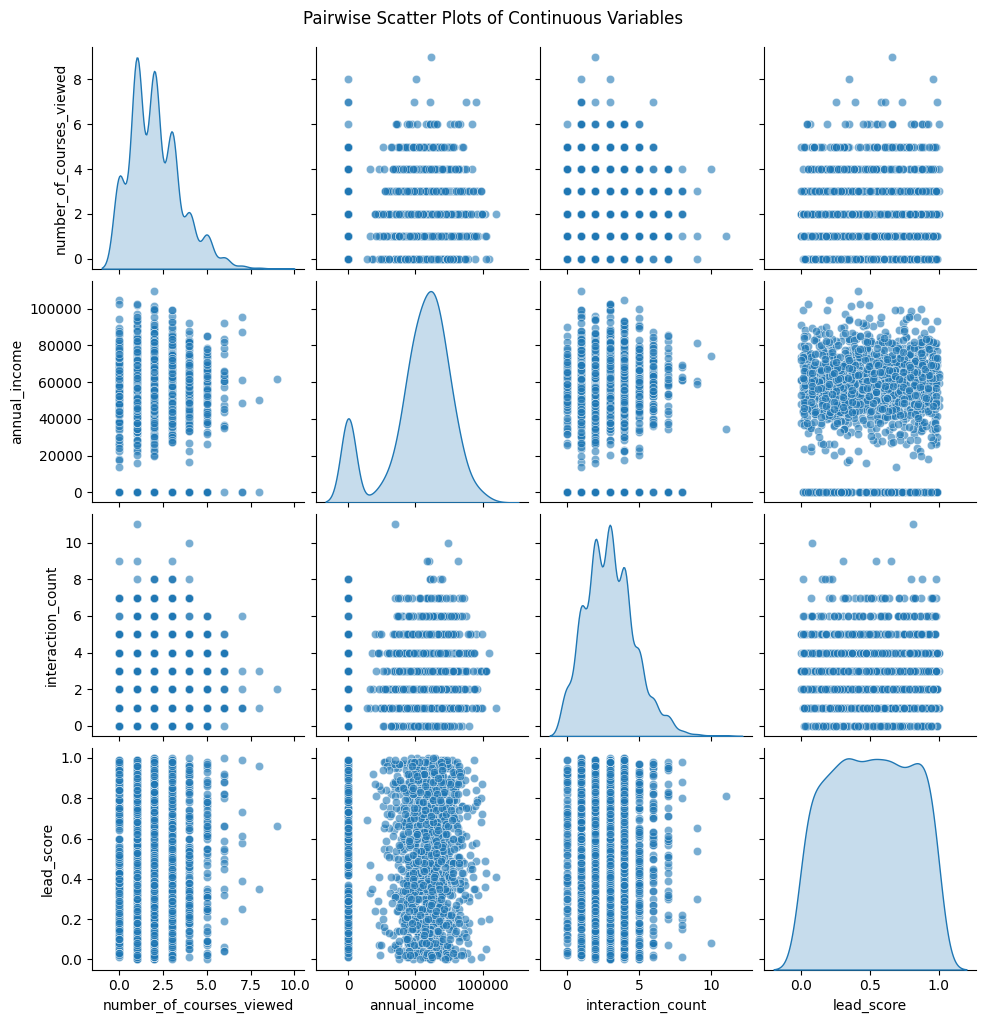

In [11]:
# Visualize correlations
sns.pairplot(df.drop(columns = ['converted']), 
             diag_kind = 'kde', 
             plot_kws = {'alpha': 0.6})
plt.suptitle("Pairwise Scatter Plots of Continuous Variables", y = 1.02)
plt.show()

### Split the data

In [12]:
# Rough idea of ns for train, val, test
n_total = df.shape[0]
p60 = int(n_total * 0.6)
p20 = int(n_total * 0.2)

print(n_total, p60, p20)

1462 877 292


In [13]:
# Separate features and target
X = df.drop(columns = ['converted'])
y = df['converted']

# First, split off 20% for test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

# Split the remaining 80% into 60% train, 20% val (relative to total data)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size = 0.25, random_state = 42
)  # 0.25 * 0.8 = 0.2

datasets = [X_train_full, X_train, X_val, X_test, y_train_full, y_train, y_val, y_test]

# Reset index for all (drop old index)
for i in range(len(datasets)):
    datasets[i] = datasets[i].reset_index(drop = True)

X_train_full, X_train, X_val, X_test, y_train_full, y_train, y_val, y_test = datasets

# Check sizes
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 876, Val: 293, Test: 293


### Feature importance

In [14]:
# Outcome in training and validation data combined
round(y_train_full.value_counts(normalize = True) * 100, 1)

converted
1    60.7
0    39.3
Name: proportion, dtype: float64

In [15]:
# Correlations with outcome (training + validation)

numeric_cols = list(X_train_full.select_dtypes(include = ['number']).columns)

X_train_full[numeric_cols].corrwith(y_train_full).sort_values(ascending = False)

number_of_courses_viewed    0.442068
interaction_count           0.378482
lead_score                  0.225641
annual_income               0.029612
dtype: float64

In [16]:
# Correlations with outcome (training only)

numeric_cols = list(X_train_full.select_dtypes(include = ['number']).columns)

X_train[numeric_cols].corrwith(y_train).sort_values(ascending = False)

number_of_courses_viewed    0.426480
interaction_count           0.369941
lead_score                  0.219223
annual_income               0.016605
dtype: float64

In [17]:
# Absolute and ratio measures of importance in training and validation data combined

df_train_full = X_train_full.copy()
df_train_full['converted'] = y_train_full

categorical_cols = list(df_train_full.select_dtypes(include = ['object']).columns)

global_converted = df_train_full['converted'].mean()

for c in categorical_cols:
    print(f"\n\n{c}")
    df_group = df_train_full.groupby(c).converted.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_converted
    df_group['ratio'] = df_group['mean'] / global_converted
    display(df_group)



lead_source


,mean,count,diff,ratio
lead_source,,,,
NA,0.669725,109,0.062368,1.102688
events,0.592965,199,-0.014392,0.976304
organic_search,0.615721,229,0.008364,1.013771
paid_ads,0.428571,210,-0.178785,0.705634
referral,0.786408,206,0.179051,1.294804
social_media,0.583333,216,-0.024023,0.960446




industry


,mean,count,diff,ratio
industry,,,,
NA,0.557522,113,-0.049835,0.917948
education,0.790210,143,0.182853,1.301064
finance,0.556886,167,-0.050470,0.916901
healthcare,0.593333,150,-0.014023,0.976911
manufacturing,0.621429,140,0.014072,1.023169
other,0.612903,155,0.005547,1.009132
retail,0.566265,166,-0.041092,0.932343
technology,0.562963,135,-0.044394,0.926907




employment_status


,mean,count,diff,ratio
employment_status,,,,
NA,0.571429,84,-0.035928,0.940845
employed,0.671937,253,0.064580,1.106330
self_employed,0.635739,291,0.028382,1.046731
student,0.659722,288,0.052366,1.086219
unemployed,0.462451,253,-0.144906,0.761415




location


,mean,count,diff,ratio
location,,,,
NA,0.680000,50,0.072643,1.119606
africa,0.592857,140,-0.014500,0.976127
asia,0.588608,158,-0.018749,0.969130
australia,0.612903,155,0.005547,1.009132
europe,0.641176,170,0.033820,1.055684
middle_east,0.644172,163,0.036815,1.060615
north_america,0.589888,178,-0.017469,0.971238
south_america,0.554839,155,-0.052518,0.913530


### Question 3. Mutual information

In [18]:
# Mutual information scores (training data only)
print(mutual_info_score(X_train.lead_source, y_train))
print(mutual_info_score(X_train.industry, y_train))
print(mutual_info_score(X_train.employment_status, y_train))
print(mutual_info_score(X_train.location, y_train))

0.03539624379726594
0.011574521435657112
0.012937677269442782
0.004464157884038034


In [19]:
def mutual_info_score_converted(series):
    return mutual_info_score(series, y_train)

mi = X_train[categorical_cols].apply(mutual_info_score_converted)

mi.sort_values(ascending = False)

lead_source          0.035396
employment_status    0.012938
industry             0.011575
location             0.004464
dtype: float64

In [20]:
# Convert categorical columns to numeric codes
# X_train_cat = X_train[categorical_cols].apply(lambda col: col.astype('category').cat.codes)


# Use mutual_info_classif (for classification target y)
# mi_scores = mutual_info_classif(X_train[categorical_cols], y_train, discrete_features = True, random_state = 42)

# Store results in a DataFrame
# mi_df = pd.DataFrame({
#     'Feature': categorical_cols,
#     'Mutual Information': [round(score, 2) for score in mi_scores]
# }).sort_values(by = 'Mutual Information', ascending = False)

# print(mi_df)

### One-hot encoding

In [21]:
print(X_train.columns.tolist())

print("\nCategorical cols:", categorical_cols)
print("\nNumeric cols:", numeric_cols)

['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score']

Categorical cols: ['lead_source', 'industry', 'employment_status', 'location']

Numeric cols: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [22]:
train_dicts = X_train[categorical_cols + numeric_cols].to_dict(orient = 'records')
val_dicts = X_val[categorical_cols + numeric_cols].to_dict(orient = 'records')

dv = DictVectorizer(sparse = False)

X_train_transform = dv.fit_transform(train_dicts)
X_val_transform = dv.transform(val_dicts)

### Logistic regression

In [23]:
model = LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000, random_state = 42)
model.fit(X_train_transform, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [24]:
# Bias (intercept)

print(model.intercept_[0].round(4))

-0.0691


In [25]:
# Weights (paramters/coefficients)

model.coef_.round(4)

array([[-0.    , -0.0147,  0.0339,  0.0027,  0.0115, -0.1025, -0.0249,
         0.0494, -0.0201, -0.0134, -0.003 , -0.0093, -0.0318, -0.0161,
         0.3113,  0.0512,  0.0202, -0.012 , -0.0116, -0.1153,  0.0795,
        -0.0299,  0.004 , -0.0114, -0.0112, -0.0056,  0.0083,  0.0056,
        -0.0334, -0.0253,  0.4538]])

In [26]:
# Hard predictions
model.predict(X_train_transform)

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,

In [27]:
# Soft predictions
model.predict_proba(X_train_transform)[:, 1]

array([0.57914343, 0.87283491, 0.58816106, 0.51231211, 0.63666475,
       0.75521068, 0.67660732, 0.80463891, 0.31931235, 0.52336705,
       0.42762898, 0.75635962, 0.36365335, 0.479759  , 0.66891574,
       0.79118097, 0.84805492, 0.75295599, 0.74242974, 0.44250074,
       0.59299541, 0.71532757, 0.89505926, 0.40505602, 0.41274906,
       0.49397089, 0.76167979, 0.54183227, 0.91299586, 0.84329958,
       0.43502339, 0.8413228 , 0.45134426, 0.7333119 , 0.69094239,
       0.63501138, 0.78633979, 0.70340975, 0.31374644, 0.66994888,
       0.81195513, 0.54070748, 0.52703677, 0.66105373, 0.89692378,
       0.93952744, 0.69103809, 0.57569837, 0.43601078, 0.58839132,
       0.40836197, 0.62054107, 0.59360953, 0.80782454, 0.55881103,
       0.89447257, 0.85676682, 0.3290991 , 0.88454471, 0.61158866,
       0.55737895, 0.80158813, 0.29433961, 0.76846368, 0.26685382,
       0.61036624, 0.70840796, 0.76184472, 0.88772862, 0.60724473,
       0.74046877, 0.39672339, 0.94279447, 0.89334272, 0.77167

In [28]:
y_train_pred = model.predict_proba(X_train_transform)[:, 1]

In [29]:
y_val_pred = model.predict_proba(X_val_transform)[:, 1]
y_val_pred

array([0.61192163, 0.79982617, 0.53021343, 0.47131479, 0.57066131,
       0.44227168, 0.87127669, 0.84883115, 0.83290037, 0.61497801,
       0.54968026, 0.78153088, 0.69039785, 0.77017122, 0.5265944 ,
       0.91706425, 0.53170634, 0.42123048, 0.30146455, 0.84881583,
       0.79488653, 0.73670374, 0.4452721 , 0.64838383, 0.4176882 ,
       0.75393418, 0.90166116, 0.33903048, 0.43181431, 0.9680681 ,
       0.92018714, 0.37487988, 0.65230099, 0.90650057, 0.75164116,
       0.64202121, 0.82250075, 0.83375553, 0.659116  , 0.30978853,
       0.78942264, 0.35546365, 0.96517758, 0.63389304, 0.51274195,
       0.53230533, 0.82287785, 0.744074  , 0.73452313, 0.68955217,
       0.46964443, 0.84539252, 0.55635243, 0.92637871, 0.65258021,
       0.61526273, 0.63816995, 0.28304018, 0.48049824, 0.57890618,
       0.35497342, 0.62175051, 0.38960777, 0.61156056, 0.85304278,
       0.75430136, 0.89185954, 0.71946458, 0.95387623, 0.89209517,
       0.75277087, 0.33850139, 0.61376593, 0.51622275, 0.64088

In [30]:
converted_decision = (y_val_pred >= 0.5)

In [31]:
converted_decision

array([ True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True, False,  True, False,  True,  True,
       False, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False, False,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False,  True,
       False,  True,  True, False,  True,  True, False,  True,  True,
       False,  True,

In [32]:
X_val[converted_decision]

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score
0,paid_ads,healthcare,3,52220.0,unemployed,europe,1,0.07
1,organic_search,technology,3,59656.0,unemployed,middle_east,4,0.65
2,events,manufacturing,0,57134.0,self_employed,north_america,4,0.13
4,referral,retail,1,54103.0,unemployed,south_america,3,0.16
6,organic_search,NA,1,0.0,student,asia,5,0.14
...,...,...,...,...,...,...,...,...
285,referral,education,3,0.0,unemployed,asia,0,0.16
286,events,technology,1,0.0,employed,asia,2,0.18
287,events,retail,5,69305.0,unemployed,australia,3,0.32
289,paid_ads,NA,1,20326.0,employed,middle_east,3,0.81


In [33]:
y_val

0      0
1      1
2      0
3      0
4      0
      ..
288    0
289    1
290    0
291    1
292    0
Name: converted, Length: 293, dtype: int64

In [34]:
converted_decision.astype(int)

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0])

### Question 4. Accuracy

In [35]:
(y_val == converted_decision).mean().round(2)

np.float64(0.7)

In [36]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_val_pred
df_pred['prediction'] = converted_decision.astype(int)
df_pred['actual'] = y_val
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [37]:
df_pred

,probability,prediction,actual,correct
0,0.611922,1,0,False
1,0.799826,1,1,True
2,0.530213,1,0,False
3,0.471315,0,0,True
4,0.570661,1,0,False
...,...,...,...,...
288,0.419342,0,0,True
289,0.710539,1,1,True
290,0.418185,0,0,True
291,0.744835,1,1,True


In [38]:
df_pred.correct.mean().round(2)

np.float64(0.7)

### Question 5. Feature selection

In [39]:
print(X_train.columns.tolist())

print("\nCategorical cols:", categorical_cols)
print("Numeric cols:", numeric_cols)

train_dicts = X_train[categorical_cols + numeric_cols].to_dict(orient = 'records')
val_dicts = X_val[categorical_cols + numeric_cols].to_dict(orient = 'records')

dv = DictVectorizer(sparse = False)

X_train_transform = dv.fit_transform(train_dicts)
X_val_transform = dv.transform(val_dicts)

model = LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000, random_state = 42)
model.fit(X_train_transform, y_train)

train_acc = model.score(X_train_transform, y_train)
val_acc   = model.score(X_val_transform, y_val)

print(f"\nTraining accuracy: {train_acc:.3f}")
print(f"Validation accuracy: {val_acc:.3f}")

['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score']

Categorical cols: ['lead_source', 'industry', 'employment_status', 'location']
Numeric cols: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

Training accuracy: 0.739
Validation accuracy: 0.700


In [40]:
categorical_cols = ['lead_source', 'industry', 'employment_status', 'location']
numeric_cols = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
all_features = categorical_cols + numeric_cols

def train_and_evaluate(X_train, y_train, X_val, y_val, features):
    # Convert to dictionary format (only for selected features)
    train_dicts = X_train[features].to_dict(orient = 'records')
    val_dicts   = X_val[features].to_dict(orient = 'records')
    
    # Encode
    dv = DictVectorizer(sparse = False)
    X_train_enc = dv.fit_transform(train_dicts)
    X_val_enc   = dv.transform(val_dicts)
    
    # Train model
    model = LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000, random_state = 42)
    model.fit(X_train_enc, y_train)
    
    # Evaluate
    return accuracy_score(y_val, model.predict(X_val_enc))

In [41]:
baseline_acc = train_and_evaluate(X_train, y_train, X_val, y_val, all_features)
print(f"Baseline accuracy: {baseline_acc:.4f}")

Baseline accuracy: 0.6997


In [42]:
results = []

for f in all_features:
    reduced_features = [col for col in all_features if col != f]
    acc = train_and_evaluate(X_train, y_train, X_val, y_val, reduced_features)
    diff = baseline_acc - acc
    results.append((f, acc, diff))

# Store as DataFrame
feature_importance = pd.DataFrame(results, columns = ['Feature', 'Accuracy_without', 'Accuracy_drop'])
feature_importance = feature_importance.sort_values(by = 'Accuracy_drop', ascending = False)

print(feature_importance)

                    Feature  Accuracy_without  Accuracy_drop
4  number_of_courses_viewed          0.556314       0.143345
6         interaction_count          0.556314       0.143345
2         employment_status          0.696246       0.003413
1                  industry          0.699659       0.000000
0               lead_source          0.703072      -0.003413
7                lead_score          0.706485      -0.006826
3                  location          0.709898      -0.010239
5             annual_income          0.853242      -0.153584


'industry' has the smallest difference.

### Question 6. Parameter tuning

In [43]:
# Regularization parameters to try
C_values = [0.01, 0.1, 1, 10, 100]

# Prepare data dictionaries (same for all models)
train_dicts = X_train[all_features].to_dict(orient = 'records')
val_dicts   = X_val[all_features].to_dict(orient = 'records')

# Encode using DictVectorizer
dv = DictVectorizer(sparse = False)
X_train_enc = dv.fit_transform(train_dicts)
X_val_enc   = dv.transform(val_dicts)

# Store results
results = []

for C in C_values:
    model = LogisticRegression(solver = 'liblinear', C = C, max_iter = 1000, random_state = 42)
    model.fit(X_train_enc, y_train)
    
    acc = accuracy_score(y_val, model.predict(X_val_enc))
    results.append((C, round(acc, 3)))

# Create a results DataFrame
results_df = pd.DataFrame(results, columns = ['C', 'Validation_Accuracy'])

print(results_df)

        C  Validation_Accuracy
0    0.01                  0.7
1    0.10                  0.7
2    1.00                  0.7
3   10.00                  0.7
4  100.00                  0.7
